In [1]:
import pandas as pd
import numpy as np
import skimage as ski
import os
import tqdm
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
tqdm.tqdm.pandas()

# Data preparation

In [4]:
SOURCE_DIR = './datasets/foggy-cityscapes-image-dataset'
CLASSES = []
for root, dirs, files in os.walk(SOURCE_DIR):
    for name in dirs:
        CLASSES.append(name)
CLASSES = sorted(CLASSES)
CLASSES

['Dense_Fog', 'Medium_Fog', 'No_Fog']

In [6]:
# Create dataset - image_path, class
data = []
for c in CLASSES:
    for root, dirs, files in os.walk(os.path.join(SOURCE_DIR, c)):
        for name in files:
            data.append([os.path.join(root, name), c])
data = pd.DataFrame(data, columns=['image_path', 'class'])
data.head()

,image_path,class
0,./datasets/foggy-cityscapes-image-dataset/Dens...,Dense_Fog
1,./datasets/foggy-cityscapes-image-dataset/Dens...,Dense_Fog
2,./datasets/foggy-cityscapes-image-dataset/Dens...,Dense_Fog
3,./datasets/foggy-cityscapes-image-dataset/Dens...,Dense_Fog
4,./datasets/foggy-cityscapes-image-dataset/Dens...,Dense_Fog


In [11]:
# Encode class variable
categories = pd.Categorical(data['class'])
# Print mapping
print(categories.categories)
data['class'] = categories.codes
data.head()

Index(['Dense_Fog', 'Medium_Fog', 'No_Fog'], dtype='object')


,image_path,class
0,./datasets/foggy-cityscapes-image-dataset/Dens...,0
1,./datasets/foggy-cityscapes-image-dataset/Dens...,0
2,./datasets/foggy-cityscapes-image-dataset/Dens...,0
3,./datasets/foggy-cityscapes-image-dataset/Dens...,0
4,./datasets/foggy-cityscapes-image-dataset/Dens...,0


In [12]:
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42, stratify=data['class'])
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['class'])

train_df.shape, val_df.shape, test_df.shape

((1050, 2), (225, 2), (225, 2))

# Idea 1

1. Convert image to grayscale
2. Create histogram of colors
3. Pass this histogram to model

In [48]:
def extract_features_from_image(image_path: str):
    image = ski.io.imread(image_path)
    # Convert image to grayscale
    image = image.mean(axis=2)
    # Return histogram of pixel values
    histogram, _ = ski.exposure.histogram(image, nbins=256)
    histogram = histogram.reshape(-1, 8).sum(axis=1)
    histogram = histogram / histogram.sum()
    return histogram
    

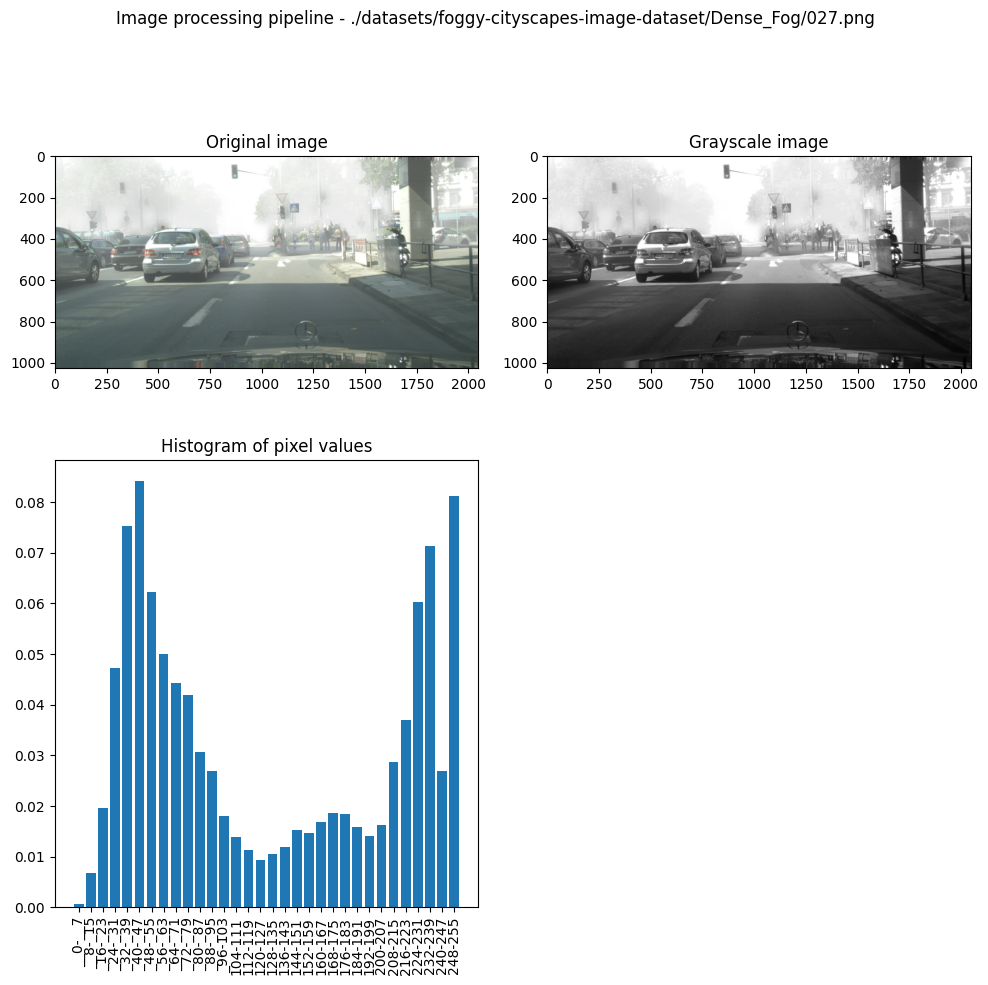

In [47]:
image_path = train_df['image_path'].values[0]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Title
fig.suptitle(f'Image processing pipeline - {image_path}')

image = ski.io.imread(image_path)
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original image')

image = ski.color.rgb2gray(image)
axs[0, 1].imshow(image, cmap='gray')
axs[0, 1].set_title('Grayscale image')

histogram, _ = ski.exposure.histogram(image, nbins=256)
histogram = histogram / histogram.sum()
# Group by 8
histogram = histogram.reshape(-1, 8).sum(axis=1)
axs[1, 0].bar(np.arange(len(histogram)), histogram)
labels = [f'{i*8:_>3}-{(i+1)*8-1:_>3}' for i in range(len(histogram))]
axs[1, 0].set_xticks(np.arange(len(histogram)))
axs[1, 0].set_xticklabels(labels, rotation=90)
axs[1, 0].set_title('Histogram of pixel values')

# delete axs[1, 1]
fig.delaxes(axs[1, 1])

# tight layout
plt.tight_layout()

plt.show()

In [52]:
# Map images to features
train_df['features'] = train_df['image_path'].progress_map(extract_features_from_image)
val_df['features'] = val_df['image_path'].progress_map(extract_features_from_image)
test_df['features'] = test_df['image_path'].progress_map(extract_features_from_image)

100%|██████████| 225/225 [00:41<00:00,  5.45it/s]


In [53]:
# Save datasets as pickle files
train_df.to_pickle(f"{SOURCE_DIR}/IDEA1_train.pkl")
val_df.to_pickle(f"{SOURCE_DIR}/IDEA1_val.pkl")
test_df.to_pickle(f"{SOURCE_DIR}/IDEA1_test.pkl")

# Training

In [37]:
train_df = pd.read_pickle(f"{SOURCE_DIR}/IDEA1_train.pkl")
val_df = pd.read_pickle(f"{SOURCE_DIR}/IDEA1_val.pkl")
test_df = pd.read_pickle(f"{SOURCE_DIR}/IDEA1_test.pkl")

## Simple

In [5]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import ClassifierMixin
from typing import Any, TypeVar
from collections import namedtuple

In [69]:
_T = TypeVar('_T', bound=ClassifierMixin)

In [71]:
def evaluate_model(model: ClassifierMixin, X: Any, y: Any):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro')
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')
    confusion = confusion_matrix(y, y_pred)
    return namedtuple('Evaluation', ['accuracy', 'f1', 'precision', 'recall', 'confusion'])(accuracy, f1, precision, recall, confusion)

In [72]:
def train_model(
        model_cls: _T, 
        model_kwargs: dict[str, Any],
        train_df: pd.DataFrame,
        val_df: pd.DataFrame
    ) -> _T:
    model = model_cls(**model_kwargs)
    model.fit(np.stack(train_df['features'].values), train_df['class'])
    train_metrics = evaluate_model(model, np.stack(train_df['features'].values), train_df['class'])
    val_metrics = evaluate_model(model, np.stack(val_df['features'].values), val_df['class'])
    print(f"Model - {model_cls.__name__}")
    print("\tTrain metrics:")
    print(f"\t\tAccuracy: {train_metrics.accuracy:.4f}")
    print(f"\t\tF1: {train_metrics.f1:.4f}")
    print(f"\t\tPrecision: {train_metrics.precision:.4f}")
    print(f"\t\tRecall: {train_metrics.recall:.4f}")
    print("\tValidation metrics:")
    print(f"\t\tAccuracy: {val_metrics.accuracy:.4f}")
    print(f"\t\tF1: {val_metrics.f1:.4f}")
    print(f"\t\tPrecision: {val_metrics.precision:.4f}")
    print(f"\t\tRecall: {val_metrics.recall:.4f}")
    return model

In [65]:
svc = train_model(SVC, {}, train_df=train_df, val_df=val_df)

Model - SVC
	Train metrics:
		Accuracy: 0.7048
		F1: 0.7057
		Precision: 0.7071
		Recall: 0.7048
	Validation metrics:
		Accuracy: 0.6667
		F1: 0.6668
		Precision: 0.6709
		Recall: 0.6667


In [74]:
rfc = train_model(RandomForestClassifier, {}, train_df=train_df, val_df=val_df)

Model - RandomForestClassifier
	Train metrics:
		Accuracy: 1.0000
		F1: 1.0000
		Precision: 1.0000
		Recall: 1.0000
	Validation metrics:
		Accuracy: 0.6444
		F1: 0.6399
		Precision: 0.6384
		Recall: 0.6444


In [75]:
xgb = train_model(XGBClassifier, {}, train_df=train_df, val_df=val_df)

Model - XGBClassifier
	Train metrics:
		Accuracy: 1.0000
		F1: 1.0000
		Precision: 1.0000
		Recall: 1.0000
	Validation metrics:
		Accuracy: 0.6800
		F1: 0.6744
		Precision: 0.6737
		Recall: 0.6800


## Deep learning

In [9]:
CLASS_MAP = {
    c: [(1 if c == i else 0 ) for i in range(1, len(CLASSES)+1) ] 
    for c in range(len(CLASSES))
}

# One hot encode class variable
train_df['class'] = train_df['class'].map(lambda x: CLASS_MAP[x])
val_df['class'] = val_df['class'].map(lambda x: CLASS_MAP[x])
test_df['class'] = test_df['class'].map(lambda x: CLASS_MAP[x])
train_df.head()

,image_path,class,features
11,./datasets/foggy-cityscapes-image-dataset/Dens...,"[0, 0, 0]","[0.0008487701416015625, 0.008153915405273438, ..."
799,./datasets/foggy-cityscapes-image-dataset/Medi...,"[1, 0, 0]","[0.0008869171142578125, 0.00792837142944336, 0..."
462,./datasets/foggy-cityscapes-image-dataset/Dens...,"[0, 0, 0]","[0.007482051849365234, 0.03315114974975586, 0...."
1029,./datasets/foggy-cityscapes-image-dataset/No_F...,"[0, 1, 0]","[0.0014796257019042969, 0.006177425384521484, ..."
384,./datasets/foggy-cityscapes-image-dataset/Dens...,"[0, 0, 0]","[0.0015749931335449219, 0.010643959045410156, ..."


In [10]:
import torch
import torch.nn as nn
import torch.functional as F
import torchmetrics as tm
from torch.utils.data import DataLoader, Dataset
import lightning as L

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_sizes: list[int], output_size: int, activation: nn.Module=nn.ReLU):
        super(MLP, self).__init__()
        self.layers = nn.Sequential()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(activation())
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(activation())
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        return self.layers(x)

In [46]:
class PandasDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.X = np.array(df['features'].tolist(), dtype=np.float32)
        self.y = np.array(df['class'].tolist(), dtype=np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [42]:
tm.functional.classification.accuracy(torch.tensor([[0.9, 0.1, 0], [0, 1, 0]]), torch.tensor([0,1]), task='multiclass', num_classes=3)

tensor(1.)

In [47]:
class Classifier(L.LightningModule):
    def __init__(self, model: nn.Module, loss_fn: nn.Module, lr: float=1e-3):
        super(Classifier, self).__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.lr = lr

        self.train_metrics = tm.MetricCollection({
            "accuracy": tm.classification.Accuracy(task="multiclass", num_classes=len(CLASSES)),
            "f1": tm.classification.F1Score(task="multiclass", num_classes=len(CLASSES)),
            "precision": tm.classification.Precision(task="multiclass", num_classes=len(CLASSES)),
            "recall": tm.classification.Recall(task="multiclass", num_classes=len(CLASSES)),
        }, prefix="train_")
        self.validation_metrics = self.train_metrics.clone(prefix="val_")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = self.loss_fn(y_pred, y)

        self.log("train_loss", loss)
        batch_value = self.train_metrics(y_pred, y)
        self.log_dict(batch_value)
        return loss

    def on_train_epoch_end(self):
        self.train_metrics.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = self.loss_fn(y_pred, y)

        self.validation_metrics.update(y_pred, y)
        return loss
    
    def on_validation_epoch_end(self):
        self.log_dict(self.validation_metrics.compute())
        self.validation_metrics.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        return DataLoader(PandasDataset(train_df), batch_size=32, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return DataLoader(PandasDataset(val_df), batch_size=32, num_workers=8)

    def test_dataloader(self):
        return DataLoader(PandasDataset(test_df), batch_size=32, num_workers=8)

In [48]:
model = Classifier(
    MLP(32, [64, 32, 16], len(CLASSES)),
    nn.CrossEntropyLoss()
)

trainer = L.Trainer(
    max_epochs=20,
    logger=L.pytorch.loggers.TensorBoardLogger(
        save_dir="runs/classify",
        name="IDEA1/MLP",
        version=1,
    ),
    log_every_n_steps=1,
)

trainer.fit(
    model
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/next/magisterka/.venv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory runs/classify/IDEA1/MLP/version_1/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params | Mode 
----------------------------------------------------------------
0 | model              | MLP              | 4.8 K  | train
1 | loss_fn            | CrossEntropyLoss | 0      | train
2 | train_metrics      | MetricCollection | 0      | train
3 | validation_metrics | MetricCollection | 0      | train
----------------------------------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params


Epoch 19: 100%|██████████| 33/33 [00:01<00:00, 25.51it/s, v_num=1]         

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 33/33 [00:01<00:00, 25.16it/s, v_num=1]
